In [1]:
import os
import sys

import torch
import torch.nn as nn
import numpy as np
import pylab as plt
os.makedirs('./synthetic_images/', exist_ok=True)


/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Best possible Acc: 81.82051595377396


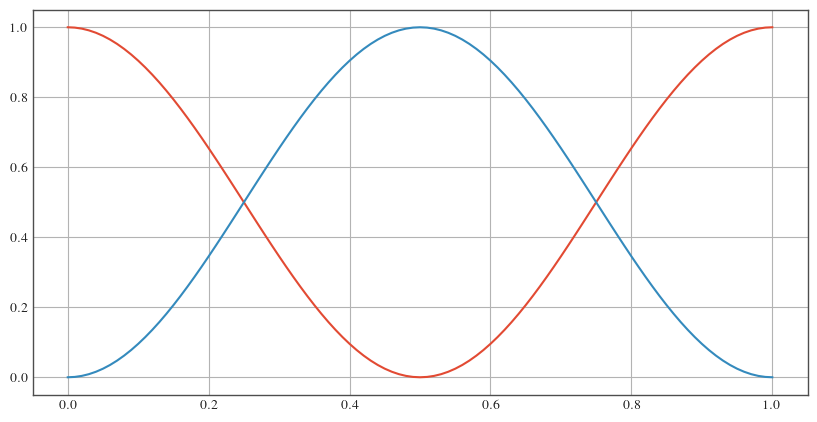

In [2]:
def f(x):
    val = np.cos(x*2*np.pi)+1
    val = val / 2
    return val

rel_px = np.linspace(0, 1, 101)
plt.plot(rel_px, f(rel_px))
plt.plot(rel_px, 1-f(rel_px))
gt_f = lambda x: np.max(np.stack((f(x), 1-f(x))), axis=0)
# plt.plot(rel_px, gt_f(rel_px))
print('Best possible Acc:', np.trapz(gt_f(rel_px)))

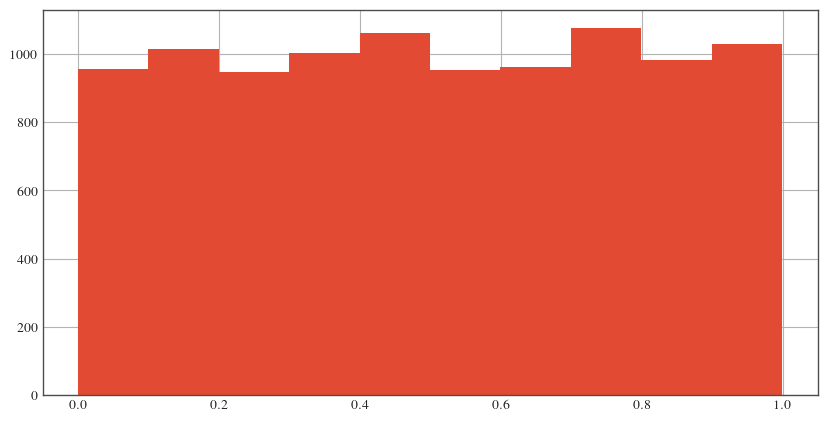

In [3]:
def create_aleatoric_data(n_samples=10_000, img_shape=(3, 32, 32), random_state=None):
    torch.manual_seed(random_state)

    all_imgs = []
    all_targets = []

    # Create a dataset in which the sum of pixels corresponds to the true probability of the label = 1
    n_pixel = np.prod(img_shape)

    for i_sample in range(n_samples):
        img = torch.zeros(n_pixel)

        # Get a random number of pixels to set to one
        n_pixel_to_one = torch.randint(high=n_pixel, size=(1,)).item()
        # Get random positions that should be set to one
        rnd_idx = torch.randperm(n_pixel)[:n_pixel_to_one]
        img[rnd_idx] = 1

        img = img.view(img_shape)
        proba = n_pixel_to_one/n_pixel
        proba = f(proba)
        label = torch.empty(1).bernoulli_(proba).long()

        all_imgs.append(img)
        all_targets.append(label)

    instances = torch.stack(all_imgs).float()
    targets = torch.cat(all_targets).long()
    return instances, targets


from torchvision.transforms import Normalize

instances, targets = create_aleatoric_data(random_state=42)
# mean = instances.mean(dim=(0, 2, 3))
# std = instances.std(dim=(0, 2, 3))
# instances  = Normalize(mean=mean, std=std)(instances)

torch.save({'instances': instances, 'targets': targets}, './synthetic_images/pixel_sum_dataset.pth')
dataset = torch.utils.data.TensorDataset(instances, targets)

plt.hist(instances.mean(dim=(1, 2, 3)))
plt.show()

10000


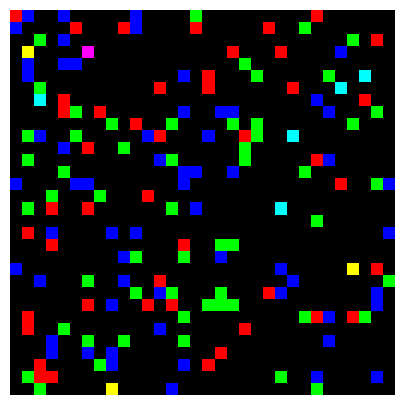

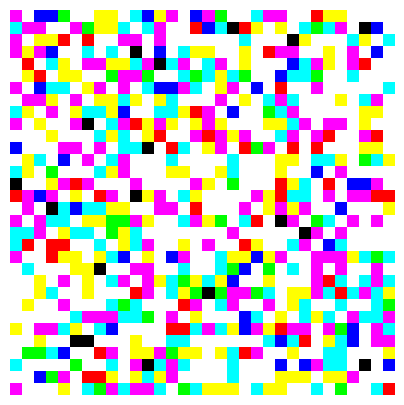

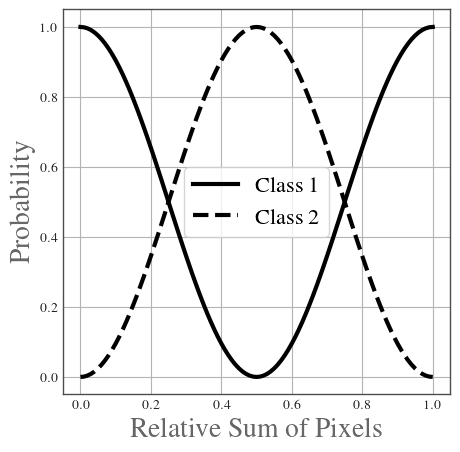

In [15]:
plt.figure(figsize=(5, 5))
print(len(dataset))
rel_pixel_sum = instances.mean(dim=(1, 2, 3))
gt_probas = f(rel_pixel_sum)

img = instances[gt_probas > .9][-2]

plt.imshow(img.permute(1, 2, 0))
plt.grid()
plt.axis('off')
plt.savefig('./synthetic_images/high_proba_instance.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(5, 5))
img = instances[(gt_probas > .45) & (gt_probas < .55)][0]
plt.imshow(img.permute(1, 2, 0))
plt.grid()
plt.axis('off')
plt.savefig('./synthetic_images/aleatoric_instance.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

# plt.figure(figsize=(5, 5))
# img = instances[gt_probas > .9][0]
# plt.imshow(img.permute(1, 2, 0))
# plt.grid()
# plt.axis('off')
# plt.savefig('./synthetic_images/high_proba_instance.pdf', bbox_inches='tight', pad_inches=0)
# plt.show()

plt.figure(figsize=(5, 5))
axis = np.linspace(0, 1, 101)
plt.plot(axis, f(axis), linewidth=3, color='k', label='Class 1')
plt.plot(axis, 1-f(axis), linewidth=3, color='k', linestyle='--', label='Class 2')
plt.xlabel('Relative Sum of Pixels', fontdict={'fontsize': 20})
plt.ylabel('Probability', fontdict={'fontsize': 20})
plt.legend(**{'fontsize': 16})
plt.savefig('./synthetic_images/ds_info.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [12]:

img = instances[(gt_probas > .45) & (gt_probas < .55)][0]
img.mean()

tensor(0.7552)

In [9]:
from dal_toolbox.models.deterministic.resnet import ResNet18
from dal_toolbox.models.deterministic.trainer import DeterministicTrainer
from dal_toolbox.models.deterministic.evaluate import evaluate
from dal_toolbox.utils import seed_everything

seed_everything(42)

n_train_samples = int(len(dataset)*.7)
rnd_indices = np.random.permutation(len(dataset))
train_indices = rnd_indices[:n_train_samples]
test_indices = rnd_indices[n_train_samples:]
train_ds = torch.utils.data.Subset(dataset, indices=train_indices[:])
test_ds = torch.utils.data.Subset(dataset, indices=test_indices)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)

n_epochs = 10
model = ResNet18(num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=.1, momentum=.9, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

trainer = DeterministicTrainer(model, optimizer, criterion, lr_scheduler, device='cuda')
history = trainer.train(n_epochs=n_epochs, train_loader=train_loader, test_loaders={'test_loader': test_loader}, eval_every=1)
test_history = history['test_history'] 
test_stats = test_history[-1]

# Plot Samples
probs, labels = [], []
for x, y in train_ds:
    probs.append(x.mean())
    labels.append(y)
probs = torch.stack(probs)
labels = torch.stack(labels)

fig = plt.figure(figsize=(15, 5))
rel_px = np.linspace(0, 1, 101)
ax = plt.subplot(131)
fig.suptitle(test_stats)
plt.plot(rel_px, f(rel_px))
plt.plot(rel_px, 1-f(rel_px))
plt.scatter(probs, torch.zeros_like(probs), c=labels)
plt.subplot(132, sharex=ax)
plt.hist([probs[labels==1], probs[labels==0]], bins=50)
plt.subplot(133)
plt.plot([d['test_acc1'] for d in test_history])
plt.show()

Epoch [1] [ 0/55] eta: 0:01:38 lr: 0.1 loss: 0.7485 (0.7485) acc1: 42.1875 (42.1875) time: 1.7998 data: 0.0018 max mem: 641
Epoch [1] Total time: 0:00:05
Epoch [2] [ 0/55] eta: 0:00:03 lr: 0.09755282581475769 loss: 0.3774 (0.3774) acc1: 82.8125 (82.8125) time: 0.0586 data: 0.0011 max mem: 728
Epoch [2] Total time: 0:00:03
Epoch [3] [ 0/55] eta: 0:00:03 lr: 0.09045084971874738 loss: 0.3823 (0.3823) acc1: 84.3750 (84.3750) time: 0.0602 data: 0.0011 max mem: 728


KeyboardInterrupt: 

Acc: 81.00000762939453  TCE: 0.028634384274482727


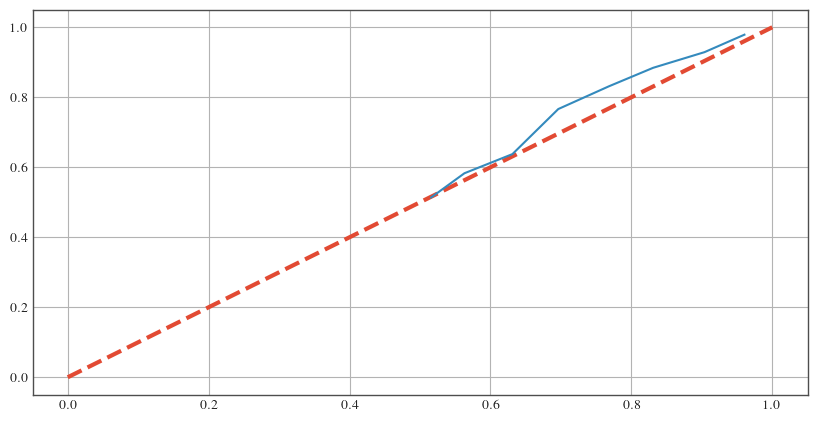

In [10]:
from dal_toolbox.metrics import calibration, generalization

@torch.inference_mode()
def forward_loader(model, dataloader, device='cpu'):
    model.to(device)

    all_logits = []
    all_targets = []
    for images, targets in dataloader:
        logits = model(images.to(device))
        all_logits.append(logits.cpu())
        all_targets.append(targets)
    logits = torch.cat(all_logits)
    targets = torch.cat(all_targets)
    return {'logits': logits, 'targets': targets}

outputs = forward_loader(model, test_loader, device='cuda')

tce_criterion = calibration.TopLabelCalibrationError()
tce = tce_criterion(outputs['logits'].softmax(-1), outputs['targets'])
acc, = generalization.accuracy(outputs['logits'], outputs['targets'])

plt.plot([0, 1], [0, 1], linestyle='--', linewidth=3)
plt.plot(tce_criterion.results['confs'], tce_criterion.results['accs'])
print('Acc: {}  TCE: {}'.format(acc, tce))

In [11]:
import tqdm
hparams = dict(
    n_reps=10,
    n_samples=20,
    n_epochs=50,
    val_split=.7,
    train_batch_size=128,
    lr=.01,
    momentum=.9,
    weight_decay=0.0
)

tmp = {}

for n_samples in tqdm.tqdm([2, 5, 10, 20, 50, 100, 200, 300, 500]):
    hparams['n_samples'] = n_samples

    results = []
    for seed in range(hparams['n_reps']):
        seed_everything(seed)
        n_train_samples = int(len(dataset)*hparams['val_split'])
        rnd_indices = np.random.permutation(len(dataset))
        train_indices = rnd_indices[:n_train_samples]
        test_indices = rnd_indices[n_train_samples:]

        train_ds = torch.utils.data.Subset(dataset, indices=train_indices[:hparams['n_samples']])
        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=hparams['train_batch_size'], shuffle=True)

        test_ds = torch.utils.data.Subset(dataset, indices=test_indices)
        test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)

        model = ResNet18(num_classes=2)
        optimizer = torch.optim.SGD(model.parameters(), lr=hparams['lr'], momentum=hparams['momentum'], weight_decay=hparams['weight_decay'])
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=hparams['n_epochs'])
        criterion = nn.CrossEntropyLoss()
        trainer = DeterministicTrainer(model, optimizer=optimizer, lr_scheduler=lr_scheduler, criterion=criterion, device='cuda')

        trainer.train(n_epochs=hparams['n_epochs'], train_loader=train_loader)
        test_stats = trainer.evaluate(test_loader)
        print(test_stats)
        results.append(test_stats)

    test_accs = [d['test_acc1'] for d in results]
    tmp[n_samples] = test_accs

    print('Test Accuracy: {:.3f} ± {:.3f}'.format(np.mean(test_accs), np.std(test_accs)))

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [1] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.4525 (0.4525) acc1: 100.0000 (100.0000) time: 0.0122 data: 0.0002 max mem: 728
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.009990133642141357 loss: 0.0140 (0.0140) acc1: 100.0000 (100.0000) time: 0.0125 data: 0.0002 max mem: 728
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.009960573506572389 loss: 0.0013 (0.0013) acc1: 100.0000 (100.0000) time: 0.0110 data: 0.0001 max mem: 728
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.009911436253643442 loss: 0.0002 (0.0002) acc1: 100.0000 (100.0000) time: 0.0120 data: 0.0002 max mem: 728
Epoch [4] Total time: 0:00:00
Epoch [5] [0/1] eta: 0:00:00 lr: 0.009842915805643154 loss: 0.0000 (0.0000) acc1: 100.0000 (100.0000) time: 0.0100 data: 0.0001 max mem: 728
Epoch [5] Total time: 0:00:00
Epoch [6] [0/1] eta: 0:00:00 lr: 0.009755282581475767 loss: 0.0000 (0.0000) acc1: 100.0000 (100.0000) time: 0.0122 data: 0.0002 max mem: 728
Epoch [6] Total time

  0%|          | 0/9 [00:04<?, ?it/s]

{'test_loss': 5.676159381866455, 'test_acc1': 35.30000305175781, 'test_nll': 5.676159381866455, 'test_brier': 1.225156545639038, 'test_tce': 0.568331778049469, 'test_mce': 0.611560583114624}
Epoch [1] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.8957 (0.8957) acc1: 0.0000 (0.0000) time: 0.0088 data: 0.0002 max mem: 728
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.009990133642141357 loss: 0.0077 (0.0077) acc1: 100.0000 (100.0000) time: 0.0096 data: 0.0001 max mem: 728
Epoch [2] Total time: 0:00:00


KeyboardInterrupt: 

In [122]:
for n_samples, test_accs in tmp.items():
    print('N = {} Test Accuracy: {:.3f} ± {:.3f}'.format(n_samples, np.mean(test_accs), np.std(test_accs) /np.sqrt(1)))

N = 2 Test Accuracy: 46.417 ± 5.696
N = 5 Test Accuracy: 53.043 ± 3.548
N = 10 Test Accuracy: 52.513 ± 4.303
N = 20 Test Accuracy: 58.727 ± 9.200
N = 50 Test Accuracy: 53.530 ± 4.357
N = 100 Test Accuracy: 53.617 ± 4.041
N = 200 Test Accuracy: 80.537 ± 0.701
N = 300 Test Accuracy: 79.127 ± 2.300
N = 500 Test Accuracy: 80.310 ± 0.732
